In [109]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import re

### Data

In [67]:
charting_df = pd.read_csv('data/charting-m-points.csv', encoding = "ISO-8859-1")

/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_15577/2249881497.py:1: DtypeWarning: Columns (8,9,29) have mixed types. Specify dtype option on import or set low_memory=False.
  charting_df = pd.read_csv('data/charting-m-points.csv', encoding = "ISO-8859-1")


In [71]:
charting_df.head(1)

,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,...,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount
0,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,1,0,0,0.0,0.0,0-0,1 (1),1,0,...,NaN,False,False,False,False,False,False,1,1,1


### Exploration

In [172]:
wimbeldon_chart_df = charting_df[charting_df['match_id'].str.contains('Wimbledon')]

#### Winning Shot Statistics

In [173]:
# get rows for both 1st and 2nd
wimbeldon_chart_1st = wimbeldon_chart_df[wimbeldon_chart_df['1st'].notna()]
wimbeldon_chart_2nd = wimbeldon_chart_df[wimbeldon_chart_df['2nd'].notna()]

In [175]:
rallys = wimbeldon_chart_1st['1st']
rallys = rallys.append(wimbeldon_chart_2nd['2nd'])

/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_15577/3234859012.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rallys = rallys.append(wimbeldon_chart_2nd['2nd'])


In [176]:
rallys.shape

(78705,)

In [187]:
# sequences of rallies that end with '*' represent a winner was hit
# winners_df_1st = wimbeldon_chart_1st[wimbeldon_chart_1st['1st'].str.contains("\*")]
# winners_df_2nd = wimbeldon_chart_2nd[wimbeldon_chart_2nd['2nd'].str.contains("\*")]
winning_shots = rallys[rallys.str.contains("\*")]

In [159]:
#winners_df = winners_df_1st['1st']
#winners_df = winners_df.append(winners_df_2nd['2nd'])

/var/folders/0w/7qj8hh4n3w53g1qsr8gf4s_w0000gn/T/ipykernel_15577/450896268.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  winners_df = winners_df.append(winners_df_2nd['2nd'])


In [188]:
winning_shots.shape

(20290,)

In [189]:
# 1st value: winners
# 2nd value: total occurences of this shot selection in general
shot_map = {
    'f': [0, 0,'fh gs'],
    'b': [0, 0,'bh gs'],
    'r': [0, 0, 'fh slice'],
    's': [0, 0, 'bh slice'],
    'v': [0, 0,'fh volley'],
    'z': [0, 0,'bh volley'],
    'o': [0, 0,'oh smash'],
    'p': [0, 0,'bh smash'],
    'u': [0, 0,'fh drop'],
    'y': [0, 0,'bh drop'],
    'l': [0, 0,'fh lob'],
    'm': [0, 0,'bh lob'],
    'h': [0, 0,'fh hv'],
    'i': [0, 0,'bh hv'],
    'j': [0, 0,'fh sv'],
    'k': [0, 0,'bh sv'],
    't': [0, 0,'trickshot'],
    'q': [0, 0,'unknown'],
    'c': [0, 0,'challenge']
}

#### get winning shots

In [190]:
num_of_winning_shots = 0
for i in winning_shots:
    if len(i) > 2: # ignore aces for now
        winning_shot = i[-4:]
        match = re.search(r'{letter_regex}'.format(letter_regex=letter_regex), winning_shot)
        if match:
            shot = match[0]
            if shot == 'd':
                winning_shot = i[-5:]
                match = re.search(r'{letter_regex}'.format(letter_regex=letter_regex), winning_shot)  
                shot = match[0]
            num_of_winning_shots += 1
            shot_map[shot.lower()][0] += 1
            

In [197]:
shot_map

{'f': [4865, 0, 'fh gs'],
 'b': [2681, 0, 'bh gs'],
 'r': [91, 0, 'fh slice'],
 's': [311, 0, 'bh slice'],
 'v': [2122, 0, 'fh volley'],
 'z': [1896, 0, 'bh volley'],
 'o': [1221, 0, 'oh smash'],
 'p': [61, 0, 'bh smash'],
 'u': [165, 0, 'fh drop'],
 'y': [138, 0, 'bh drop'],
 'l': [93, 0, 'fh lob'],
 'm': [111, 0, 'bh lob'],
 'h': [81, 0, 'fh hv'],
 'i': [65, 0, 'bh hv'],
 'j': [139, 0, 'fh sv'],
 'k': [29, 0, 'bh sv'],
 't': [2, 0, 'trickshot'],
 'q': [10, 0, 'unknown'],
 'c': [244, 0, 'challenge']}

#### get total occurences of shot in general and build df for viz

In [195]:
all_rallys_str = ''.join(list(rallys))

In [198]:
df = []
for shot, stats in shot_map.items():
    total_shots = all_rallys_str.count(shot)
    stats[1] = total_shots
    df.append({
        'shot': stats[2],
        'total': stats[1],
        'winners': stats[0]
    })

In [199]:
shot_map

{'f': [4865, 63776, 'fh gs'],
 'b': [2681, 49124, 'bh gs'],
 'r': [91, 4477, 'fh slice'],
 's': [311, 22149, 'bh slice'],
 'v': [2122, 6178, 'fh volley'],
 'z': [1896, 7183, 'bh volley'],
 'o': [1221, 1978, 'oh smash'],
 'p': [61, 212, 'bh smash'],
 'u': [165, 667, 'fh drop'],
 'y': [138, 889, 'bh drop'],
 'l': [93, 1124, 'fh lob'],
 'm': [111, 2260, 'bh lob'],
 'h': [81, 1116, 'fh hv'],
 'i': [65, 1236, 'bh hv'],
 'j': [139, 302, 'fh sv'],
 'k': [29, 71, 'bh sv'],
 't': [2, 99, 'trickshot'],
 'q': [10, 134, 'unknown'],
 'c': [244, 2916, 'challenge']}

In [201]:
shot_selection_df = pd.DataFrame(df)

In [203]:
shot_selection_df =  shot_selection_df.sort_values("total", ascending=False)

In [204]:
shot_selection_df

,shot,total,winners
0,fh gs,63776,4865
1,bh gs,49124,2681
3,bh slice,22149,311
5,bh volley,7183,1896
4,fh volley,6178,2122
2,fh slice,4477,91
18,challenge,2916,244
11,bh lob,2260,111
6,oh smash,1978,1221
13,bh hv,1236,65


#### Plots

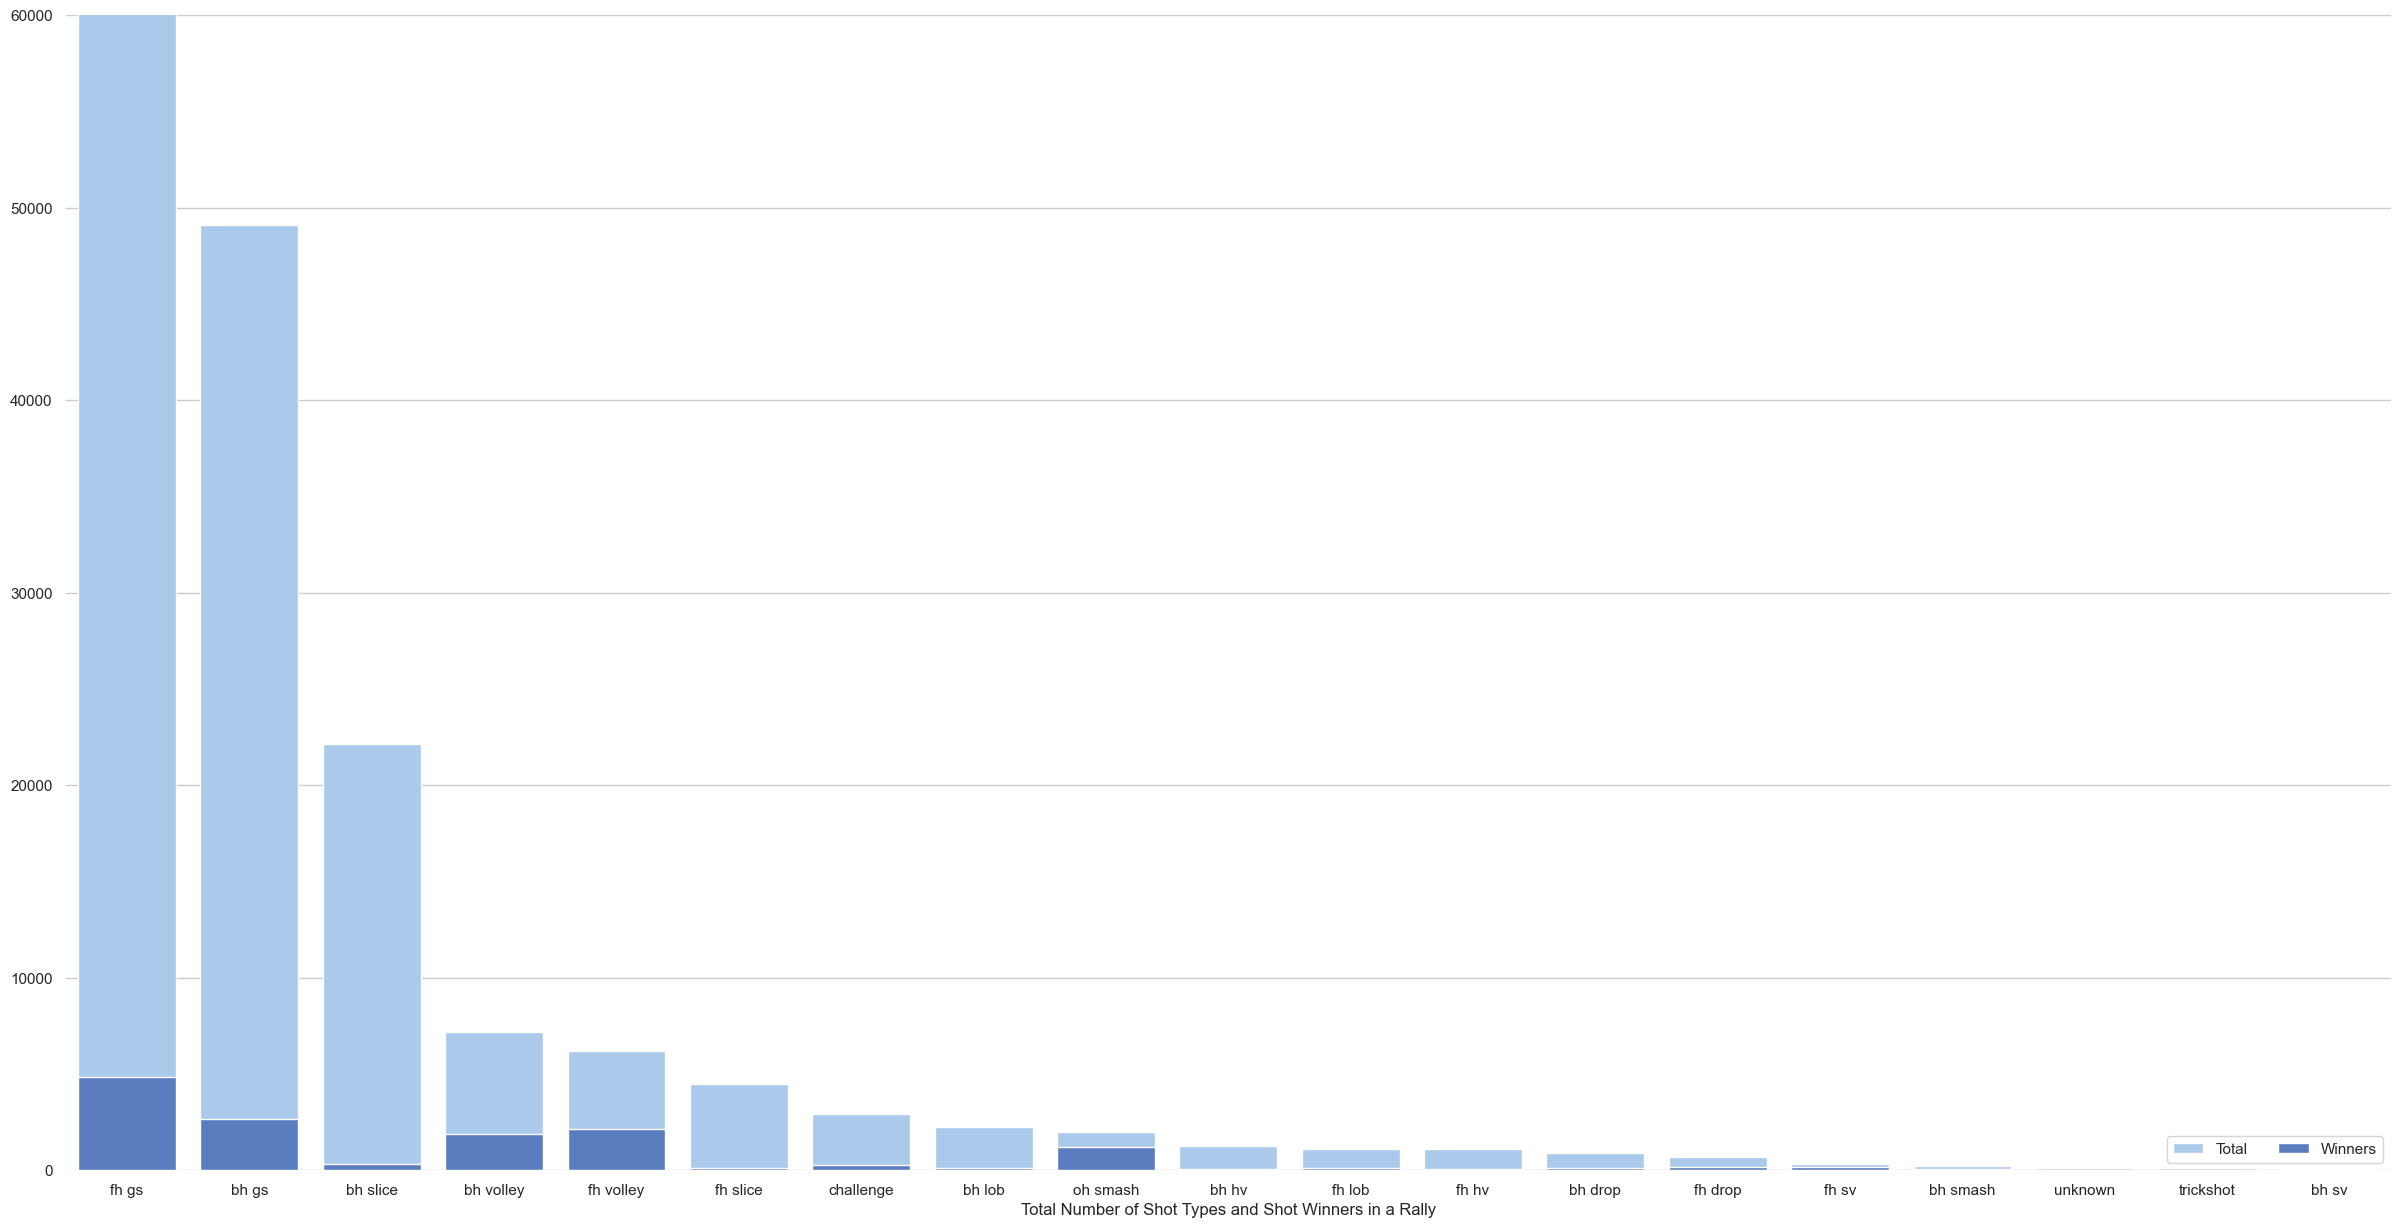

In [211]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(30, 15))


sns.set_color_codes("pastel")
sns.barplot(x="shot", y="total", data=shot_selection_df,
            label="Total", color="b")


sns.set_color_codes("muted")
sns.barplot(x="shot", y="winners", data=shot_selection_df,
            label="Winners", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylim=(0, 60000), ylabel="",
       xlabel="Total Number of Shot Types and Shot Winners in a Rally")
sns.despine(left=True, bottom=True)

In [213]:
sns.savefig("shot_fig.png")

AttributeError: module 'seaborn' has no attribute 'savefig'